In [7]:
import cv2
import torch
import torch.nn as nn
import numpy as np
import json

import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm

from Datasets.dataload import Path_Image_Preprocessing,Image_Preprocessing
from interpretability.Semantically_interpretable import Segmantically_Attributes
from utils import *

import matplotlib.pyplot as plt

## How to Erasing

In [1]:
def Erasing(image,mask,method):
    '''
    image: (H,W,3)
    mask: (H,W) save pixel set 1
    method: black, white, mean, random
    '''
    if method == "black":
        image_mask = (image.transpose(2,0,1)*mask).transpose(1,2,0)
        image_mask = Image.fromarray(cv2.cvtColor(np.uint8(image_mask),cv2.COLOR_BGR2RGB))
        return image_mask
    elif method == "white":
        mask_white = np.ones(mask.shape)*(1-mask)*255
        image_mask = (image.transpose(2,0,1)*mask+mask_white).transpose(1,2,0)
        image_mask = Image.fromarray(cv2.cvtColor(np.uint8(image_mask),cv2.COLOR_BGR2RGB))
        return image_mask
    elif method == "mean":
        mask_mean = np.ones(mask.shape)*(1-mask)*125
        image_mask = (image.transpose(2,0,1)*mask+mask_mean).transpose(1,2,0)
        image_mask = Image.fromarray(cv2.cvtColor(np.uint8(image_mask),cv2.COLOR_BGR2RGB))
        return image_mask
    elif method == "random":
        mask_random = np.ones(mask.shape)*(1-mask) * np.random.randint(0,256,(3,mask.shape[0],mask.shape[1]))
        mask_random = mask_random.transpose(1,2,0)
        image_mask = (image.transpose(2,0,1)*mask).transpose(1,2,0) + mask_random
        image_mask = Image.fromarray(cv2.cvtColor(np.uint8(image_mask),cv2.COLOR_BGR2RGB))
        return image_mask
    #np.random.randint(0,256,(3,4))

In [4]:
# Load Recognition Network
recognition_net = get_network('VGGFace2')
if torch.cuda.is_available():
    recognition_net.cuda()
recognition_net.eval()

# Load Attributes Network
attribute_net = get_network(None,'./pre-trained/Face-Attributes2.pth')
if torch.cuda.is_available():
    attribute_net.cuda()
attribute_net.eval()
seg_attr = Segmantically_Attributes(recognition_net,attribute_net,'GradCAM')

Model parameters: ./pre-trained/Face-Attributes2.pth has been load!


In [5]:
thresh = 0.5

path1 = "./Verification/dataset/CelebA-test/162216.jpg"
path2 = "./Verification/dataset/CelebA-test/073764.jpg"

image1 = Path_Image_Preprocessing("VGGFace2",path1).numpy()
image2 = Path_Image_Preprocessing("VGGFace2",path2).numpy()

seg_attr_interpretable1, index1, index2, attribute_id1, scores_attr1 = seg_attr.topk_Identity_Segmantically_Attributes_Interpretable(image1,image2,1)
seg_attr_interpretable1 = 1 - seg_attr_interpretable1

seg_attr_interpretable1[seg_attr_interpretable1<thresh] = 0
seg_attr_interpretable1[seg_attr_interpretable1>thresh] = 1

In [6]:
image = cv2.imread(path1)
image_black = Erasing(image,seg_attr_interpretable1[0],method="black")
image_white = Erasing(image,seg_attr_interpretable1[0],method="white")
image_mean = Erasing(image,seg_attr_interpretable1[0],method="mean")
image_random = Erasing(image,seg_attr_interpretable1[0],method="random")

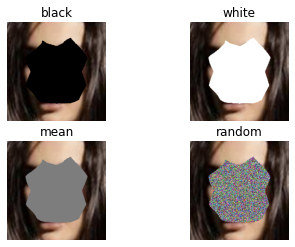

In [8]:
plt.subplot(2,2,1)
plt.axis('off')
plt.title("black")
plt.imshow(image_black)

plt.subplot(2,2,2)
plt.axis('off')
plt.title("white")
plt.imshow(image_white)

plt.subplot(2,2,3)
plt.axis('off')
plt.title("mean")
plt.imshow(image_mean)

plt.subplot(2,2,4)
plt.axis('off')
plt.title("random")
plt.imshow(image_random)

(224, 224)